This notebook contains the code for running baseline model 1: PreMet-DNN

PreMet-DNN is deep neurla network, trained in 1-vs-Rest manner to predict metastasis directly from primary tumor gene expressino profiles.

In [28]:
import pandas as pd
import numpy as np
import anndata as ann
import scanpy as sc
import os, sys
from scipy.stats import pearsonr as pr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score as f1
from sklearn.metrics import precision_recall_curve as prc
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, average_precision_score


In [29]:
sc.set_figure_params(dpi=400)

# Load Anndata

In [30]:
# load data
adata = sc.read('METMAP500.h5ad')
adata

/home/wang3712/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 259 × 1512
    obs: 'Tissue', 'prim_or_metas', 'metas_site'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [31]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

/home/wang3712/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


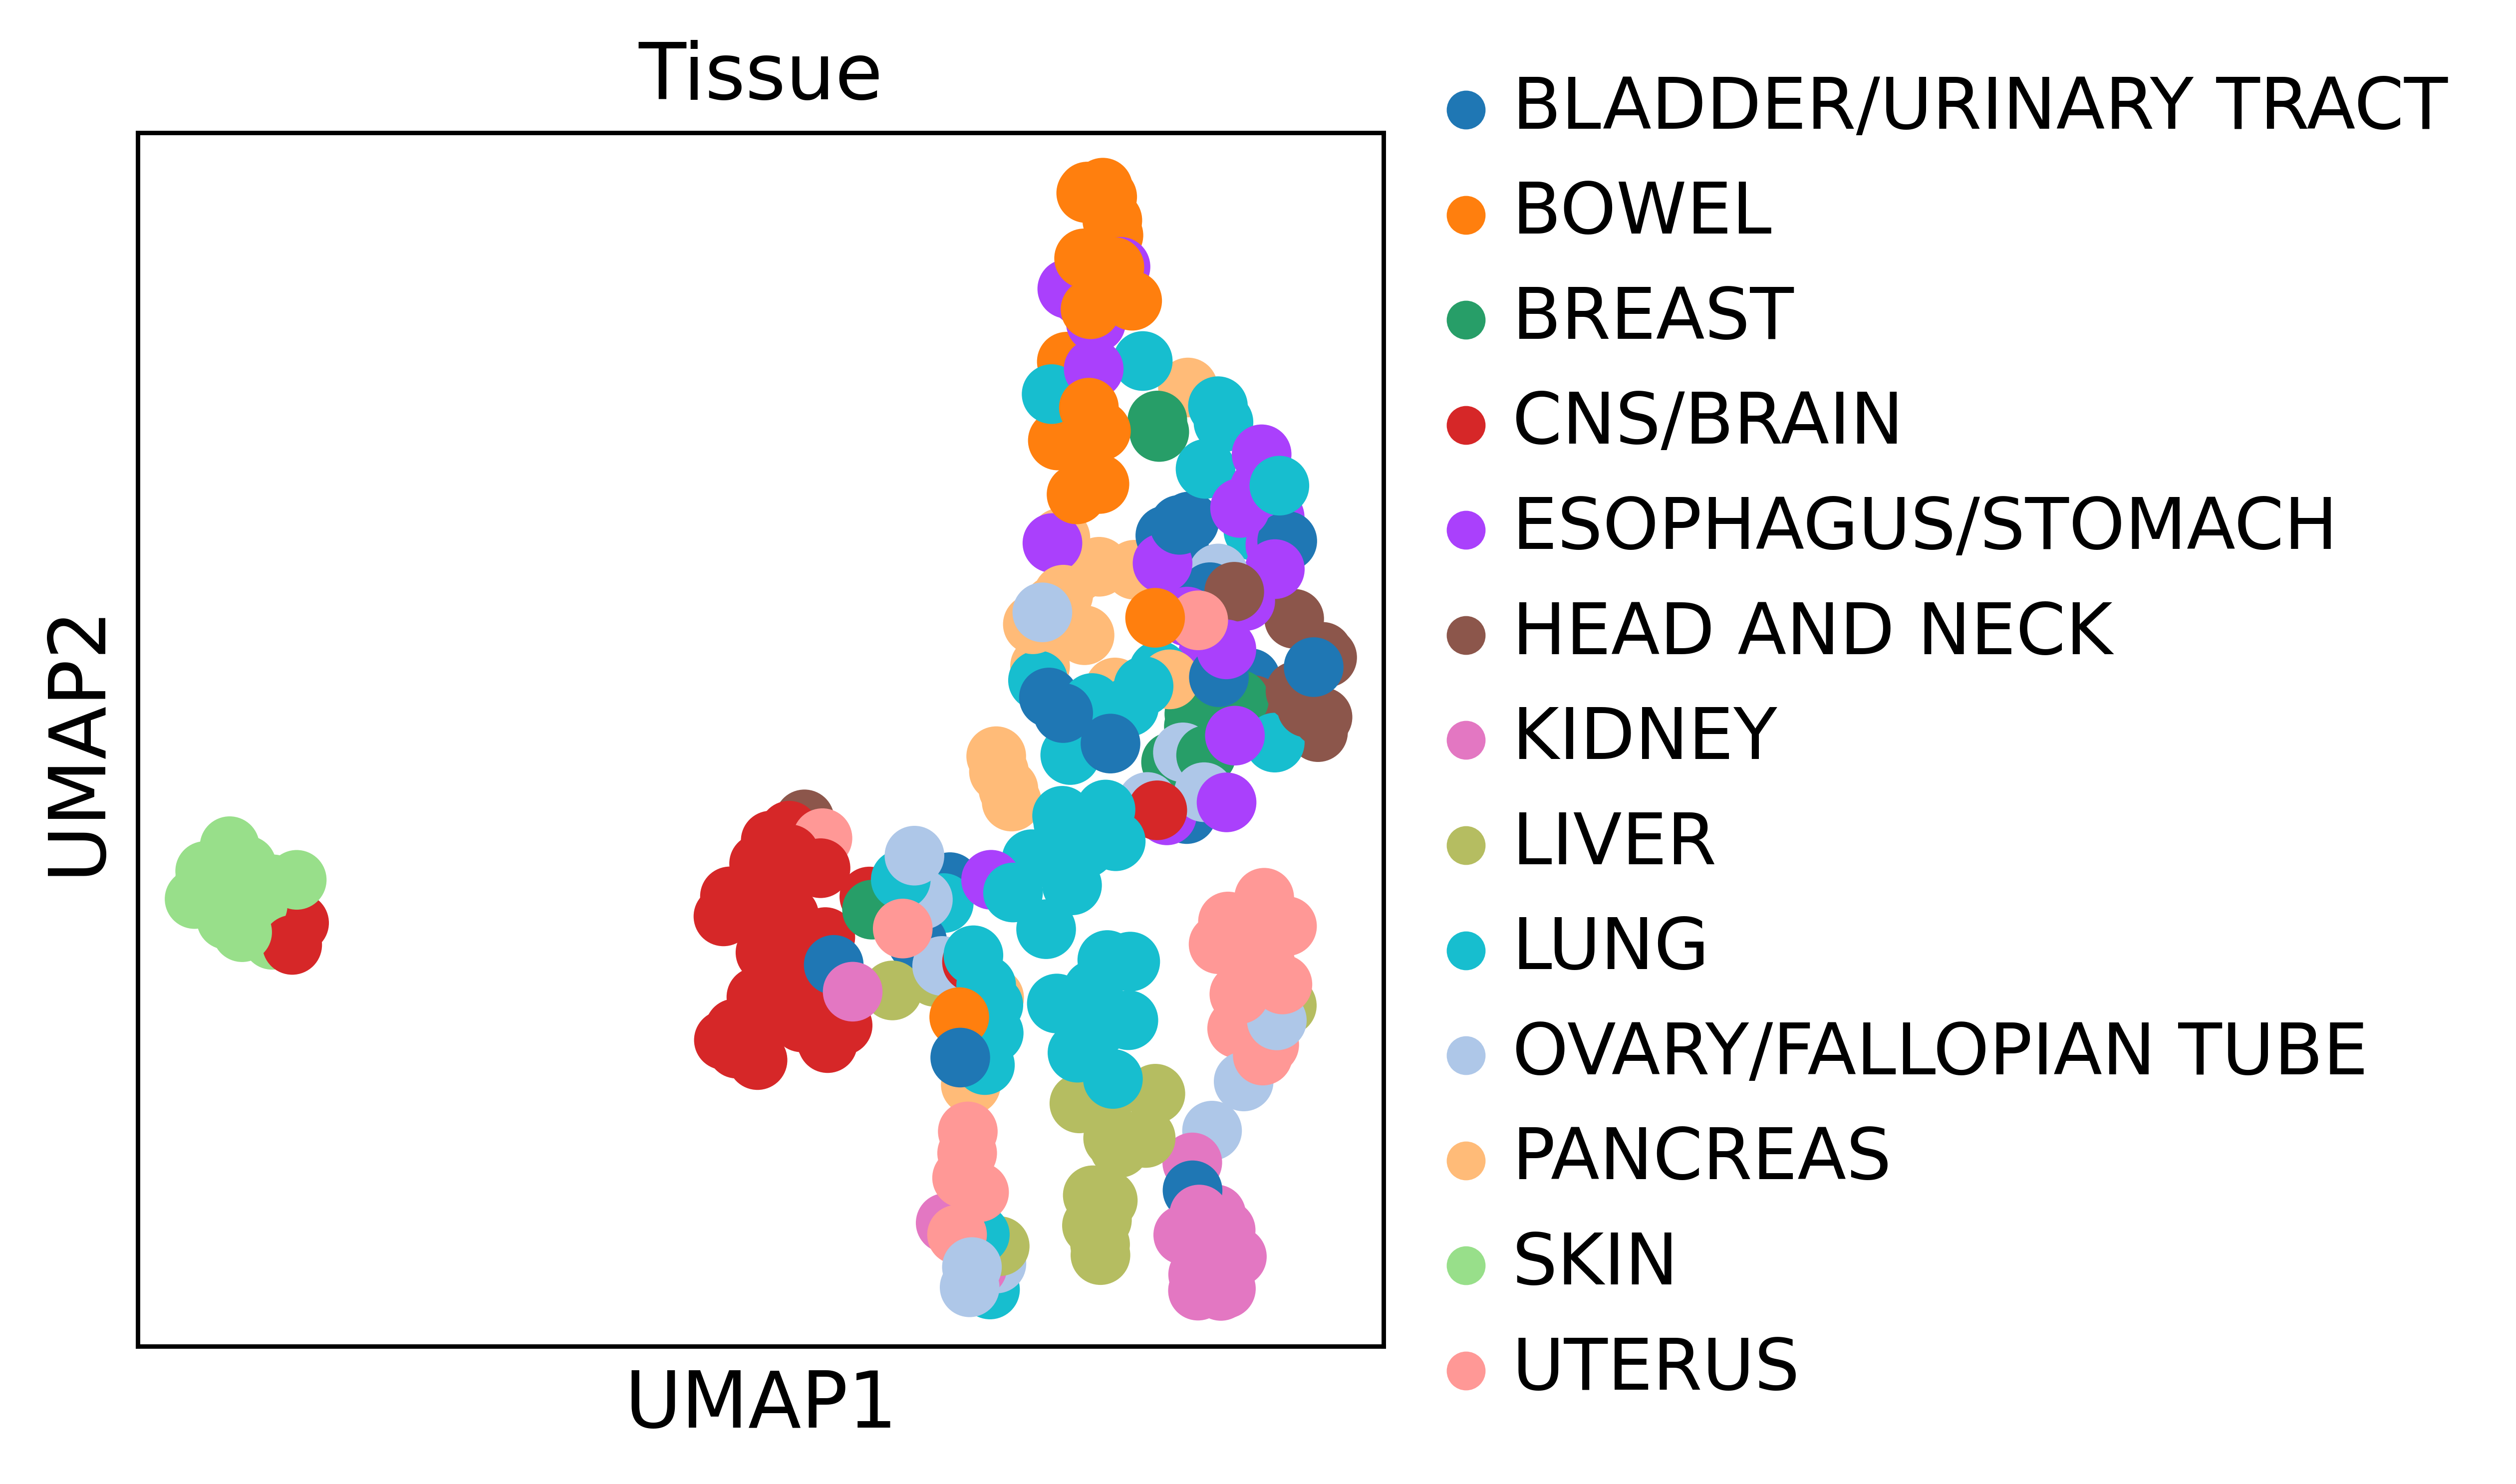

In [32]:
sc.pl.umap(adata, color='Tissue')
# sc.pl.pca(adata, color='Tissue')

/home/wang3712/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


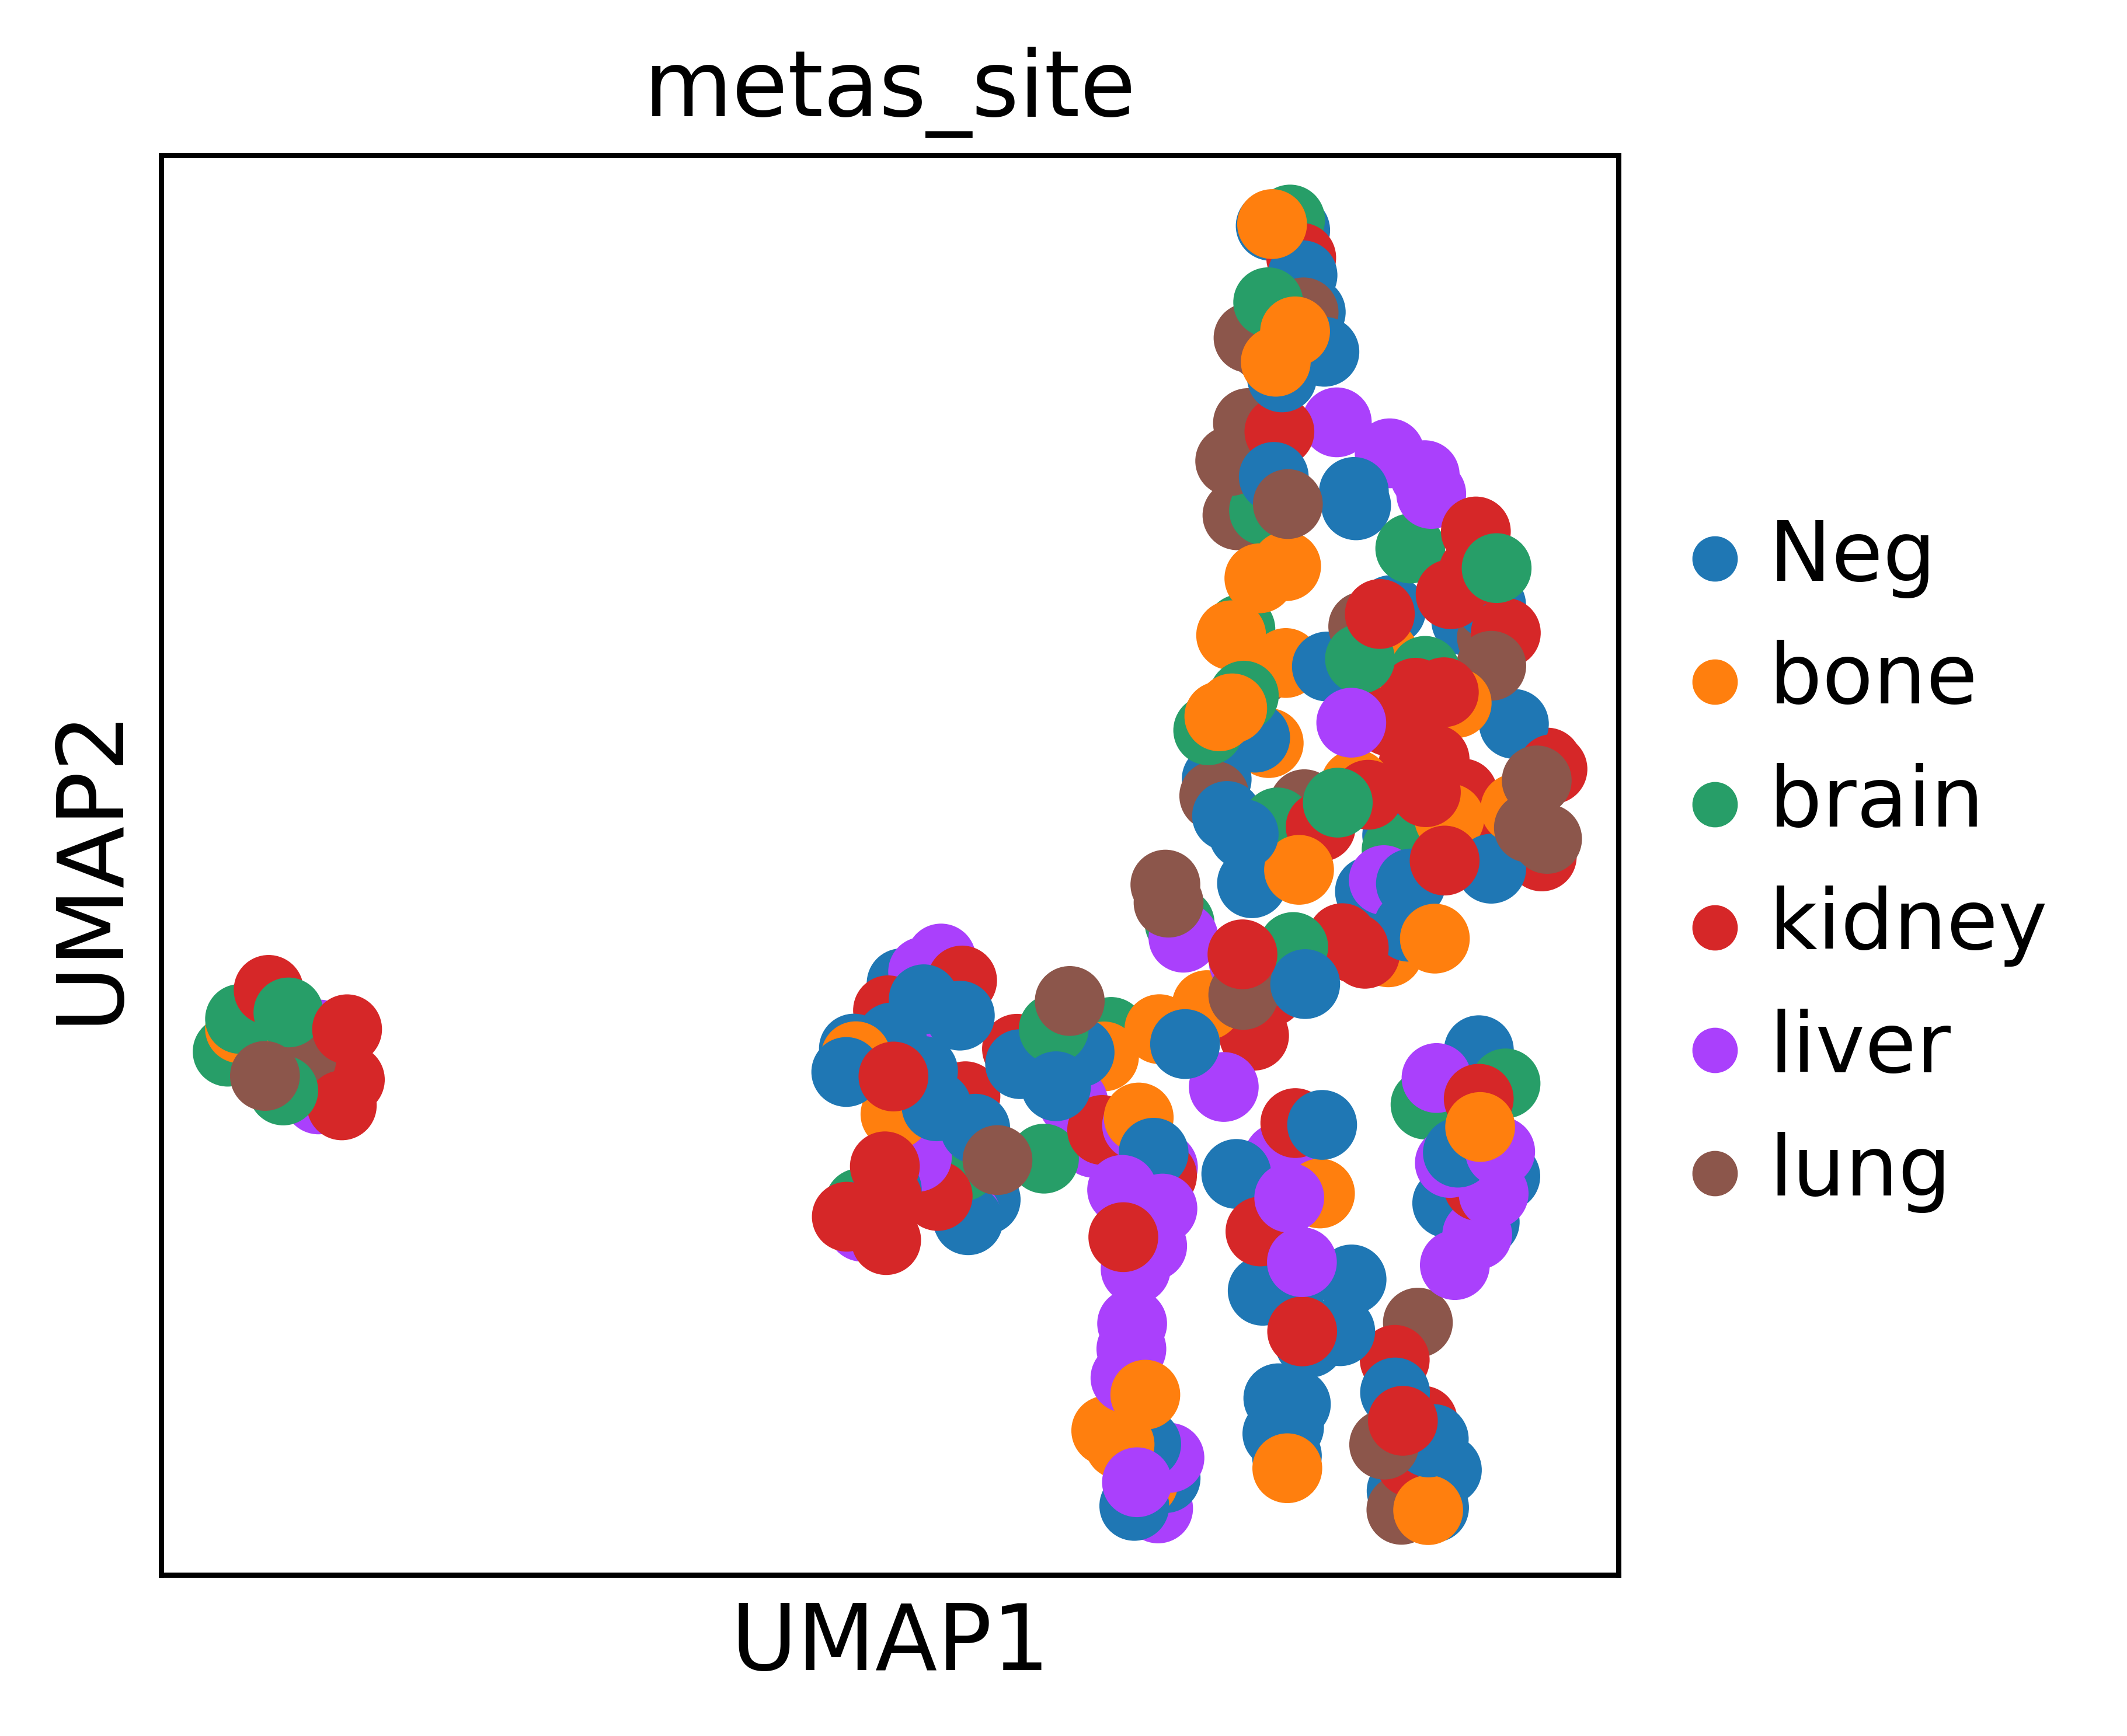

In [33]:
sc.pl.umap(adata, color='metas_site')


In [34]:
# reformat the tissue as just the name
from collections import Counter
all_tissues = adata.obs['Tissue'].unique()
new_tissues = []
for tissue in adata.obs['Tissue']:
    if tissue.startswith('CNS/BRAIN'):
        new_tissues.append('BRAIN')
    else:
        new_tissues.append(tissue.split('/')[0].split('_')[0])
adata.obs['new_tissue'] = new_tissues
adata.obs['new_tissue'].unique()

array(['BOWEL', 'SKIN', 'LUNG', 'BLADDER', 'BRAIN', 'PANCREAS', 'OVARY',
       'KIDNEY', 'HEAD AND NECK', 'UTERUS', 'LIVER', 'BREAST',
       'ESOPHAGUS'], dtype=object)

# One hot encoding

In [35]:
# one hot encoding the labels
def one_hot_encode(labels, num_classes):
    unique_labels = list(set(labels))
    
    one_hot_encoded = np.zeros(shape=(len(labels), num_classes))

    # Encode labels by setting the corresponding index to 1 in each row
    for i, label in enumerate(labels):
        index = unique_labels.index(label)
        one_hot_encoded[i, index] = 1

    return one_hot_encoded, unique_labels

In [36]:
one_hot_labels_tissue,_ = one_hot_encode(adata.obs['new_tissue'], len(adata.obs['new_tissue'].unique()))

In [37]:
one_hot_labels_site, uniqe_labels_site = one_hot_encode(adata.obs['metas_site'], len(adata.obs['metas_site'].unique()))

In [38]:
one_hot_labels_site_one_vs_all = dict()
all_sites = adata.obs.metas_site.value_counts().index
for tissue in all_sites:
    print(tissue)
    tissues_to_learn = tissue
    one_vs_all_labels = []
    for i in adata.obs.metas_site:
        if  i == tissues_to_learn:
            one_vs_all_labels.append(1)
        else:
            one_vs_all_labels.append(0)
    adata.obs[tissue+'.1va'] = one_vs_all_labels
    one_hot_labels_site_one_vs_all[tissue], _ = one_hot_encode(adata.obs[tissue+'.1va'], len(adata.obs[tissue+'.1va'].unique()))

Neg
kidney
liver
bone
lung
brain


# Dataloader

In [39]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [51]:
class GeneExpressionDataset(torch.utils.data.Dataset):
    def __init__(self, data, tumors, metas_sites):
        self.data = data  # gene expression data (shape: N x num_genes)
        self.tumors = tumors  # primary tumor type information
        self.site = metas_sites # metastasis sites

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        expression = self.data[idx]  # single gene expression vector
        tumor = self.tumors[idx] 
        site = self.site[idx]
        return expression, tumor, site

In [41]:
# min max normalization
df_normalized = adata.to_df().apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
df_normalized

,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001617,ENSG00000001626,ENSG00000002586,ENSG00000002726,ENSG00000002822,ENSG00000003147,ENSG00000003402,...,ENSG00000259207,ENSG00000261052,ENSG00000264424,ENSG00000271503,ENSG00000275385,ENSG00000275410,ENSG00000275718,ENSG00000275896,ENSG00000277443,ENSG00000277586
ACH-000007,0.001362,0.418544,0.369698,0.106475,0.408904,0.474120,0.458151,0.440864,0.464034,0.260111,...,0.001478,0.279958,0.017318,0.068780,0.000000,0.219731,0.493214,0.421571,0.273935,0.049319
ACH-000008,0.006430,0.477888,0.343918,0.017110,0.016921,0.478341,0.010205,0.480758,0.066012,0.335006,...,0.545344,0.276866,0.001148,0.127957,0.065129,0.003036,0.007540,0.011576,0.222305,0.393855
ACH-000012,0.191250,0.456729,0.308974,0.020991,0.001036,0.381573,0.035220,0.272343,0.308789,0.430792,...,0.112426,0.328580,0.000000,0.033411,0.000000,0.325642,0.004284,0.000000,0.372882,0.002864
ACH-000015,0.257558,0.451050,0.317799,0.103040,0.004082,0.413896,0.000636,0.338382,0.172822,0.322058,...,0.024053,0.230060,0.000000,0.024011,0.000000,0.002155,0.005483,0.000000,0.280227,0.057089
ACH-000018,0.153213,0.479226,0.263913,0.387343,0.000931,0.644546,0.009856,0.399677,0.156312,0.350153,...,0.242461,0.310473,0.000000,0.144101,0.000000,0.274338,0.000000,0.088571,0.421349,0.004805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000996,0.074882,0.440487,0.295306,0.185086,0.048008,0.288487,0.006353,0.286848,0.340713,0.236046,...,0.164890,0.289611,0.000000,0.085934,0.000000,0.233327,0.004805,0.080224,0.190480,0.000000
ACH-000997,0.003535,0.544124,0.340695,0.161163,0.027014,0.531133,0.003096,0.303902,0.374838,0.413348,...,0.011084,0.287474,0.000000,0.000000,0.000000,0.218204,0.030232,0.003117,0.249225,0.006531
ACH-001016,0.034719,0.436016,0.333444,0.196966,0.012406,0.571435,0.000000,0.319017,0.000000,0.367459,...,0.217110,0.375106,0.000000,0.005349,0.000000,0.000000,0.000000,0.000000,0.490580,0.000862
ACH-001113,0.086371,0.221148,0.484695,0.234437,0.000000,0.387764,0.007274,0.227263,0.124448,0.373009,...,0.076591,0.368189,0.000000,0.019027,0.000000,0.000000,0.000000,0.000000,0.509043,0.410519


# Stratified Five fold CV

In [44]:
all_data = GeneExpressionDataset(torch.tensor(df_normalized.to_numpy(), dtype=torch.float32), 
                                 torch.tensor(one_hot_labels_tissue, dtype=torch.float32),
                                 torch.tensor(one_hot_labels_site, dtype=torch.float32))

In [45]:
from sklearn.model_selection import StratifiedKFold

# Convert to class indices
tissue_labels = np.argmax(one_hot_labels_tissue, axis=1)  # Convert one-hot to class indices
site_labels = np.argmax(one_hot_labels_site, axis=1)  # Convert one-hot to class indices

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  # Use a fixed random_state for repeatability

# Store seeds and indices
cv_splits = []

batch_size = 8

# Iterate through the splits
for fold, (train_idx, val_idx) in enumerate(skf.split(df_normalized.to_numpy(), site_labels)):
    print(f'Fold {fold+1}')
    
    # Extract the training and validation data based on the indices
    train_data = torch.utils.data.Subset(all_data, train_idx)
    val_data = torch.utils.data.Subset(all_data, val_idx)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    # Save the split for later use (optional)
    cv_splits.append({'train_idx': train_idx, 'val_idx': val_idx})
    
    # Check stratification by printing unique labels in the validation set
    val_tissue_labels = np.argmax(one_hot_labels_tissue[val_idx], axis=1)
    val_site_labels = np.argmax(one_hot_labels_site[val_idx], axis=1)
    
    print('Validation Tissue Labels:', np.unique(val_tissue_labels, return_counts=True), len(np.unique(val_tissue_labels)))
    print('Validation Site Labels:', np.unique(val_site_labels, return_counts=True), len(np.unique(val_site_labels)))
    print('*'*15)

Fold 1
Validation Tissue Labels: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12]), array([4, 6, 5, 3, 3, 1, 5, 4, 5, 3, 6, 7])) 12
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([ 7,  6, 11, 15,  5,  8])) 6
***************
Fold 2
Validation Tissue Labels: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 5,  2,  3,  6,  3,  2,  2,  8, 13,  1,  3,  2,  2])) 13
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([ 7,  6, 11, 15,  5,  8])) 6
***************
Fold 3
Validation Tissue Labels: (array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 7,  2,  4,  5,  3,  2, 10,  9,  2,  2,  2,  4])) 12
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([ 8,  6, 11, 14,  5,  8])) 6
***************
Fold 4
Validation Tissue Labels: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([2, 2, 7, 5, 4, 5, 2, 5, 9, 1, 3, 3, 4])) 13
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([ 8,  6, 11, 14,  5,  8])) 6
*********

# PreMet-DNN

## Model

In [48]:
class Premet_DNN(nn.Module):
    def __init__(self, num_genes, num_classes, hidden_size):
        super(Premet_DNN, self).__init__()
        # replicate sklearn structures
        self.fc1 = nn.Linear(num_genes, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)
        self.fc3 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return self.softmax(x)

## Train

In [49]:
# Create dataloaders
cv_metrics = dict()
prior_metric = dict()

best_model_dir = '/depot/natallah/data/Luopin/Metestasis/5fold_CV_baseline_1/'
if not os.path.exists(best_model_dir):
    os.mkdir(best_model_dir)

for tissue in all_sites:
    print('*'*10, 'Training for metastasis site: ', tissue, '*'*10)
    print(tissue)
    # print(adata.obs[tissue+'.1va'].value_counts())
    batch_size = 16
    cv_metrics[tissue] = dict()
    cv_metrics[tissue]['accuracy'] = []
    cv_metrics[tissue]['f1_score'] = []
    cv_metrics[tissue]['auc'] = []
    cv_metrics[tissue]['auprc'] = []
    all_data = GeneExpressionDataset(torch.tensor(df_normalized.to_numpy(), dtype=torch.float32), 
                                    torch.tensor(one_hot_labels_tissue, dtype=torch.float32),
                                    torch.tensor(one_hot_labels_site_one_vs_all[tissue], dtype=torch.float32))
    
    
    # prior_metric[tissue]
    prior_metric[tissue] = dict()
    prior_metric[tissue]['accuracy'] = []
    prior_metric[tissue]['f1_score'] = []
    prior_metric[tissue]['auc'] = []
    prior_metric[tissue]['auprc'] = []
    
    fold = 1
    
    
    for split in cv_splits:
        # Extract the training and validation data based on the indices
        train_data = torch.utils.data.Subset(all_data, split['train_idx'])
        val_data = torch.utils.data.Subset(all_data, split['val_idx'])

        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
        
        # test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True) 
        premet_dnn= Premet_DNN(adata.n_vars, len(adata.obs[tissue+'.1va'].unique()), 
                            hidden_size=int(256))
        
        criterion = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(premet_dnn.parameters(), lr=0.0001)
        
        # print out prior, for validation only
        # Calculate the prior metrics
        num_positive = val_dataloader.dataset.dataset.site[val_dataloader.dataset.indices][:, 1].detach().cpu().numpy().sum()
        num_negative = len(val_dataloader.dataset.dataset.site[val_dataloader.dataset.indices][:, 1].detach().cpu().numpy())-num_positive
        total_samples = num_positive+num_negative
        prior_accuracy = max(num_positive / total_samples, num_negative / total_samples)
        prior_f1_score = 0 if num_negative == total_samples else (2 * (num_positive / total_samples)) / (1 + (num_positive / total_samples))
        # prior_auroc = 0.5
        # Determine the most frequent class
        y_true = np.argmax(val_dataloader.dataset.dataset.site[val_dataloader.dataset.indices].detach().cpu().numpy(), axis=1)
        most_frequent_class = np.bincount(y_true).argmax()

        # Predict the most frequent class for all samples
        y_pred_prior = np.ones(len(y_true))

        # Calculate the ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred_prior)
        prior_auroc = auc(fpr, tpr)
        prior_auprc = num_positive / total_samples
        
        prior_metric[tissue]['accuracy'].append(prior_accuracy)
        prior_metric[tissue]['f1_score'].append(prior_f1_score)
        prior_metric[tissue]['auc'].append(prior_auroc)
        prior_metric[tissue]['auprc'].append(prior_auprc)
        
        print(f"Prior Accuracy: {prior_accuracy:.4f}, Prior F1 Score: {prior_f1_score:.4f}, Prior AUROC: {prior_auroc:.4f}, Prior AUPRC: {prior_auprc:.4f}")

        # print('*'*10, 'validation data', '*'*10)
        # print(f"Prior Accuracy: {prior_accuracy:.4f}, Prior F1 Score: {prior_f1_score:.4f}, Prior AUROC: {prior_auroc:.4f}, Prior AUPRC: {prior_auprc:.4f}")
        # print('*'*10, 'validation data', '*'*10)
        
        # Training loop
        train_losses = []
        validation_losses = []
        accuracies = []
        auc_scores = []
        f1_scores = []
        auprc_scores = []
        num_epochs = 2000
        
        best_accuracy = 0.0
        best_f1 = 0.0
        best_auroc = 0.0
        best_auprc = 0.0
        best_average_metric = 0.0


        # pre-training stats
        premet_dnn.eval()

        with torch.no_grad():  
            # compute AUC
            val_loss = 0.0
            pred_probs = []  
            true_labels = []  
            for data, tissues, sites in val_dataloader:
                outputs = premet_dnn(data)
                val_loss += criterion(outputs, sites).item()
                
                pred_probs.extend(outputs.detach().cpu().numpy())
                true_labels.extend(sites.detach().cpu().numpy())

            acc = accuracy_score(np.argmax(np.array(true_labels), axis=1), np.argmax(np.array(pred_probs), axis=1))
            auc_score = roc_auc_score(true_labels, pred_probs)
            f1_score = f1(np.argmax(np.array(true_labels), axis=1), np.argmax(np.array(pred_probs), axis=1))
            precision, recall, _ = prc(np.argmax(np.array(true_labels), axis=1), np.array(pred_probs)[:, 1])
            auprc = auc(recall, precision)
            
            print(f"Val loss: {val_loss:.6f} | Val acc {acc:.6f} | Val auc {auc_score:.6f} | Val f1 {f1_score:.6f} | Val auprc {auprc: 6f}")
            
            accuracies.append(acc)
            auc_scores.append(auc_score)
            f1_scores.append(f1_score)
            auprc_scores.append(auprc)
            
            
            if acc >= best_accuracy:
                best_accuracy = acc
                torch.save(premet_dnn.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.accuracy.pth')

            if auc_score >= best_auroc:
                best_auroc = auc_score
                torch.save(premet_dnn.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.auc.pth')

            if f1_score >= best_f1:
                best_f1 = f1_score
                torch.save(premet_dnn.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.f1_score.pth')


            if auprc >= best_auprc:
                best_auprc = auprc
                torch.save(premet_dnn.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.auprc.pth')
            
            # save the model based on the best average score
            if acc+auc_score+f1_score+auprc >= best_average_metric:
                best_average_metric = acc+auc_score+f1_score+auprc
                torch.save(premet_dnn.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.avg.pth')
            
            
        for epoch in range(num_epochs):
            # Initialize  loss
            train_loss = 0.0
            val_loss = 0.0

            # train
            for data, tissues, sites in train_dataloader:
                outputs = premet_dnn(data)
                loss = criterion(outputs, sites)

                # Backward pass and optimization
                optim.zero_grad()
                loss.backward()
                optim.step()

                # Accumulate loss for the epoch
                train_loss += loss.item()  # Detach loss from computational graph
        
            # Validation 
            premet_dnn.eval()
            with torch.no_grad():  
                # compute AUC
                pred_probs = []  
                true_labels = []  
                for data, tissues, sites in val_dataloader:
                    outputs = premet_dnn(data)
                    val_loss += criterion(outputs, sites).item()
                
                    pred_probs.extend(outputs.detach().cpu().numpy())
                    true_labels.extend(sites.detach().cpu().numpy())

            # Print epoch information
            # print(len(pred_probs))
            # print(len(true_labels))
            acc = accuracy_score(np.argmax(np.array(true_labels), axis=1), np.argmax(np.array(pred_probs), axis=1))
            auc_score = roc_auc_score(true_labels, pred_probs)
            f1_score = f1(np.argmax(np.array(true_labels), axis=1), np.argmax(np.array(pred_probs), axis=1))
            precision, recall, _ = prc(np.argmax(np.array(true_labels), axis=1), np.array(pred_probs)[:, 1])
            auprc = auc(recall, precision)

            # accuracies.append(acc)
            if epoch % 500 == 0:
                print(f"Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_dataloader):.8f} | Val Loss: {val_loss/len(val_dataloader):.8f} | Val accuracy: {acc:.8f} | Val AUC {auc_score:.8f}")
        
            train_losses.append(train_loss/len(train_dataloader))
            validation_losses.append(val_loss/len(val_dataloader))
            
            accuracies.append(acc)
            auc_scores.append(auc_score)
            f1_scores.append(f1_score)
            auprc_scores.append(auprc)
            
            # save the model
            if acc > best_accuracy:
                best_accuracy = acc
                torch.save(premet_dnn.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.accuracy.pth')

            if auc_score > best_auroc:
                best_auroc = auc_score
                torch.save(premet_dnn.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.auc.pth')

            if f1_score > best_f1:
                best_f1 = f1_score
                torch.save(premet_dnn.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.f1_score.pth')


            if auprc > best_auprc:
                best_auprc = auprc
                torch.save(premet_dnn.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.auprc.pth')

            if acc+auc_score+f1_score+auprc > best_average_metric:
                best_average_metric = acc+auc_score+f1_score+auprc
                torch.save(premet_dnn.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.avg.pth')
        
        """
        
        plt.plot(np.arange(len(f1_scores)), accuracies, label='Accuracy')
        plt.plot(np.arange(len(f1_scores)), auc_scores, label='AUROC')
        plt.plot(np.arange(len(f1_scores)), f1_scores, label='F1')
        plt.plot(np.arange(len(f1_scores)), auprc_scores, label='AUPRC')
        plt.grid(False)
        plt.legend()
        plt.show()
        """
       

        # print(tissue, 'acc',max(accuracies), 'auc',max(auc_scores), 'f1',max(f1_scores), 'auprc', max(auprc_scores))
        print('*'*20)
        cv_metrics[tissue]['accuracy'].append(max(accuracies))
        cv_metrics[tissue]['f1_score'].append(max(auc_scores))
        cv_metrics[tissue]['auc'].append(max(f1_scores))
        cv_metrics[tissue]['auprc'].append(max(auprc_scores))
        
        fold += 1
    
    print('#'*15, 'prior')
    
    
    for metric in prior_metric[tissue].keys():
        print(metric, np.mean(prior_metric[tissue][metric]))
    print('#'*15, '5fold CV')
    
    for metric in cv_metrics[tissue].keys():
        print(metric, np.mean(cv_metrics[tissue][metric]))
    print('#'*15)



********** Training for metastasis site:  Neg **********
Neg
Prior Accuracy: 0.7115, Prior F1 Score: 0.4478, Prior AUROC: 0.5000, Prior AUPRC: 0.2885
Val loss: 2.835070 | Val acc 0.288462 | Val auc 0.425225 | Val f1 0.447761 | Val auprc  0.237004
Epoch: 1/2000 | Train Loss: 0.64061219 | Val Loss: 0.58168087 | Val accuracy: 0.71153846 | Val AUC 0.58558559
Epoch: 501/2000 | Train Loss: 0.31344193 | Val Loss: 0.56444238 | Val accuracy: 0.69230769 | Val AUC 0.71891892
Epoch: 1001/2000 | Train Loss: 0.31326543 | Val Loss: 0.59905401 | Val accuracy: 0.67307692 | Val AUC 0.71846847
Epoch: 1501/2000 | Train Loss: 0.31326179 | Val Loss: 0.60830568 | Val accuracy: 0.67307692 | Val AUC 0.70900901
********************
Prior Accuracy: 0.7115, Prior F1 Score: 0.4478, Prior AUROC: 0.5000, Prior AUPRC: 0.2885
Val loss: 2.694154 | Val acc 0.711538 | Val auc 0.481081 | Val f1 0.000000 | Val auprc  0.339630
Epoch: 1/2000 | Train Loss: 0.61636108 | Val Loss: 0.60418892 | Val accuracy: 0.71153846 | Val AUC

## Best Model and 5fold CV

In [52]:
all_best_models = os.listdir(best_model_dir)
all_best_models.sort()

all_metrics = set()

for m in all_best_models:
    all_metrics.add(m.split('.')[-2])
all_metrics = list(all_metrics)
all_metrics.sort()
all_metrics

['accuracy', 'auc', 'auprc', 'avg', 'f1_score']

In [54]:
def premet_dnn_predict(model, data_loader):
    model.eval()
    all_labels = []
    with torch.no_grad():
        for data in data_loader:
            # print(data)
            data = data[0].to(next(model.parameters()).device) 
            labels = model.forward(data)
            all_labels.append(labels)
            
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
    return all_labels

In [59]:
final_prediction_metric_dict = dict()
prior_prediction_metric_dict = dict()

all_ground_truth_dfs = dict()
all_prediction_value_dfs = dict()

for metric_idx in range(len(all_metrics)):
    final_prediction_metric_dict[all_metrics[metric_idx]] = dict()
    prior_prediction_metric_dict[all_metrics[metric_idx]] = dict()
    all_ground_truth_dfs[all_metrics[metric_idx]] = dict()
    all_prediction_value_dfs[all_metrics[metric_idx]] = dict()
    
    fold = 1
    prior_accuracies = []
    prior_f1_scores = []
    prior_aurocs = []
    prior_auprcs = []

    accuracies = []
    f1_scores = []
    aurocs = []
    auprcs = []

    for split in cv_splits:
        # print('*' * 10, fold, '*' * 10)
        
        all_ground_truth_dfs[all_metrics[metric_idx]][fold] = dict()
        all_prediction_value_dfs[all_metrics[metric_idx]][fold] = dict()

        all_data = GeneExpressionDataset(torch.tensor(df_normalized.to_numpy(), dtype=torch.float32), 
                                         torch.tensor(one_hot_labels_tissue, dtype=torch.float32),
                                         torch.tensor(one_hot_labels_site_one_vs_all['Neg'], dtype=torch.float32))
        # Extract the training and validation data based on the indices
        val_data = torch.utils.data.Subset(all_data, split['val_idx'])
        val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)        

        # load the best model for different metrics

        for metric in [all_metrics[metric_idx]]:
            # print('+' * 10, metric, '+' * 10)
            best_models = dict()
            # load the model
            for site in all_sites:
                # print('$' * 10, site, '$' * 10)
                model = Premet_DNN(adata.n_vars, len(adata.obs[tissue+'.1va'].unique()), 
                            hidden_size=int(256))

                model.load_state_dict(torch.load(best_model_dir + site + '.split_' + str(fold) + '.' + metric + '.pth'))
                best_models[site] = model

            predictions = dict()
            ground_truth_dfs = adata.obs.iloc[split['val_idx']]
            for site in all_sites:
                preds = premet_dnn_predict(best_models[site], val_dataloader)
                # the second column indicates sample predicted to be this label
                predictions[site] = preds[:, 1]
            prediction_df = pd.DataFrame.from_dict(predictions)
            new_names = [s + '.1va' for s in all_sites]
            ground_truth_dfs = ground_truth_dfs[new_names]
            
            # save the predictions and ground truth for confusionmatrix
            all_ground_truth_dfs[all_metrics[metric_idx]][fold] = ground_truth_dfs
            all_prediction_value_dfs[all_metrics[metric_idx]][fold] = prediction_df

            # Convert the DataFrames to numpy arrays
            true_labels = ground_truth_dfs.to_numpy()
            pred_probs = prediction_df.to_numpy()

            # Calculate priors

            # Convert one-hot encoded labels to class indices
            true_labels_val = np.argmax(true_labels, axis=1)

            # Calculate the class distribution
            class_counts = np.bincount(true_labels_val)
            total_samples = len(true_labels_val)
            most_frequent_class = class_counts.max()

            # Prior Accuracy: The frequency of the most common class
            prior_accuracy = most_frequent_class / total_samples

            # Prior F1 Score: Macro F1 score assuming all samples are predicted as the most frequent class
            dummy_predictions = np.full_like(true_labels_val, fill_value=np.argmax(class_counts))  # Predicting the most frequent class for all
            prior_f1_score = f1(true_labels_val, dummy_predictions, average='macro')

            # Prior AUROC: This will be 0.5 for random guessing in multi-class problems (you can calculate class-wise AUROC if needed)
            prior_auroc = 0.5

            # Prior AUPRC: Class-wise AUPRC (One-vs-Rest)
            prior_auprc = average_precision_score(np.eye(len(class_counts))[true_labels_val], np.eye(len(class_counts))[dummy_predictions], average='macro')

            # Store prior metrics
            prior_accuracies.append(prior_accuracy)
            prior_f1_scores.append(prior_f1_score)
            prior_aurocs.append(prior_auroc)
            prior_auprcs.append(prior_auprc)

            # Calculate metrics
            accuracy = accuracy_score(np.argmax(true_labels, axis=1), np.argmax(pred_probs, axis=1))
            f1_score = f1(np.argmax(true_labels, axis=1), np.argmax(pred_probs, axis=1), average='macro')
            auroc = roc_auc_score(true_labels, pred_probs, multi_class='ovr')

            # Calculate AUPRC for each class and average
            precision = dict()
            recall = dict()
            auprc = []
            for i in range(true_labels.shape[1]):
                precision[i], recall[i], _ = prc(true_labels[:, i], pred_probs[:, i])
                auprc.append(auc(recall[i], precision[i]))
            avg_auprc = np.mean(auprc)

            # Store metrics
            accuracies.append(accuracy)
            f1_scores.append(f1_score)
            aurocs.append(auroc)
            auprcs.append(avg_auprc)


        fold += 1

    prior_prediction_metric_dict[all_metrics[metric_idx]]['f1'] = prior_f1_scores
    prior_prediction_metric_dict[all_metrics[metric_idx]]['accuracy'] = prior_accuracies
    prior_prediction_metric_dict[all_metrics[metric_idx]]['auroc'] = prior_aurocs
    prior_prediction_metric_dict[all_metrics[metric_idx]]['auprc'] = prior_auprcs
        
    final_prediction_metric_dict[all_metrics[metric_idx]]['f1'] = f1_scores
    final_prediction_metric_dict[all_metrics[metric_idx]]['accuracy'] = accuracies
    final_prediction_metric_dict[all_metrics[metric_idx]]['auroc'] = aurocs
    final_prediction_metric_dict[all_metrics[metric_idx]]['auprc'] = auprcs

    """"
    # Print average prior metrics
    print('#' * 15 + ' Average Prior Metrics ' + '#' * 15)
    print(f'Average Prior Accuracy: {np.mean(prior_accuracies):.4f}')
    print(f'Average Prior F1 Score: {np.mean(prior_f1_scores):.4f}')
    print(f'Average Prior AUROC: {np.mean(prior_aurocs):.4f}')
    print(f'Average Prior AUPRC: {np.mean(prior_auprcs):.4f}')

    # Print average metrics from predictions
    print('#' * 15 + ' Average Metrics from Predictions ' + '#' * 15)
    print(f'Average Accuracy: {np.mean(accuracies):.4f} {np.std(accuracies):.4f}')
    print(f'Average F1 Score: {np.mean(f1_scores):.4f} {np.std(f1_scores):.4f}')
    print(f'Average AUROC: {np.mean(aurocs):.4f} {np.std(aurocs):.4f}')
    print(f'Average AUPRC: {np.mean(auprcs):.4f} {np.std(auprcs):.4f}')
    """


In [67]:
# average 5 fold CV performance across different best model selection criterion (column name)

final_prediction_metric_df = pd.DataFrame.from_dict(final_prediction_metric_dict)
final_prediction_metric_df
final_prediction_metric_avg = []
for idx in final_prediction_metric_df.index:
    tmp = []
    for col in final_prediction_metric_df.columns:
        tmp.append(np.mean(final_prediction_metric_df[col].loc[idx]))
    final_prediction_metric_avg.append(tmp)

final_prediction_metric_avg_df = pd.DataFrame(final_prediction_metric_avg)
final_prediction_metric_avg_df.columns =  final_prediction_metric_df.columns
final_prediction_metric_avg_df.index =  final_prediction_metric_df.index
final_prediction_metric_avg_df

,accuracy,auc,auprc,avg,f1_score
f1,0.210685,0.167080,0.185152,0.223588,0.238170
accuracy,0.320588,0.231825,0.251357,0.328431,0.309125
auroc,0.593374,0.680630,0.667607,0.664210,0.600767
auprc,0.289719,0.341108,0.368351,0.335991,0.300809


## Table 3.1 PreMet-DNN row

In [68]:
# the avergae score across four metrics was used to select the best model (4th col above)
# these scores are reported in the manuscrip
for metric in ['avg']:
    display(pd.DataFrame.from_dict(final_prediction_metric_dict[metric]))
    print(pd.DataFrame.from_dict(final_prediction_metric_dict[metric]).mean(), '\n',
          pd.DataFrame.from_dict(final_prediction_metric_dict[metric]).std())
          

,f1,accuracy,auroc,auprc
0,0.263348,0.365385,0.647631,0.298906
1,0.204154,0.365385,0.674245,0.372081
2,0.176044,0.250000,0.635620,0.297582
3,0.190680,0.269231,0.690152,0.320804
4,0.283712,0.392157,0.673402,0.390579


f1          0.223588
accuracy    0.328431
auroc       0.664210
auprc       0.335991
dtype: float64 
 f1          0.047214
accuracy    0.064125
auroc       0.022082
auprc       0.042905
dtype: float64
